## Basic Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import networkx as nx

from platform import python_version
print("Python Version", python_version())
print('PyTorch Version', torch.__version__)

Python Version 3.7.12
PyTorch Version 1.10.0+cu111


In [ ]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = "cuda"
print("device =", DEVICE)
# Reproducibility
SEED = 3407
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# Parallel processing
NUM_CORES = 20
torch.set_num_threads(NUM_CORES)

device = cpu


In [ ]:
if DEVICE=="cpu":
    !pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
else:
    !pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
import torch_geometric as pyg
print('PyTorch Geometric Version', pyg.__version__)

     |████████████████████████████████| 291 kB 2.9 MB/s 
     |████████████████████████████████| 639 kB 33.7 MB/s 
     |████████████████████████████████| 328 kB 39.2 MB/s 
     |████████████████████████████████| 138 kB 49.4 MB/s 
     |████████████████████████████████| 325 kB 5.1 MB/s 
     |████████████████████████████████| 407 kB 51.7 MB/s 
     |████████████████████████████████| 45 kB 3.5 MB/s 
PyTorch Geometric Version 2.0.2


## Prepare graph

In [ ]:
def to_node_idx(x,y):
    return (8*x) + y

def to_coord(node_idx):
    return node_idx//8, node_idx%8

edge_index = [[],[]]
for i in range(8):
    for j in range(8):
        if i<7:
            edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i+1,j))
            edge_index[0].append(to_node_idx(i+1,j));    edge_index[1].append(to_node_idx(i,j))
            if j>0:
                edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i+1,j-1))
                edge_index[0].append(to_node_idx(i+1,j-1));    edge_index[1].append(to_node_idx(i,j))
        if i>0:
            edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i-1,j))
            edge_index[0].append(to_node_idx(i-1,j));    edge_index[1].append(to_node_idx(i,j))
            if j<7:
                edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i-1,j+1))
                edge_index[0].append(to_node_idx(i-1,j+1));    edge_index[1].append(to_node_idx(i,j))
        if j<7:
            edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i,j+1))
            edge_index[0].append(to_node_idx(i,j+1));    edge_index[1].append(to_node_idx(i,j))
            if i<7:
                edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i+1,j+1))
                edge_index[0].append(to_node_idx(i+1,j+1));    edge_index[1].append(to_node_idx(i,j))
        if j>0:
            edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i,j-1))
            edge_index[0].append(to_node_idx(i,j-1));    edge_index[1].append(to_node_idx(i,j))
            if i>0:
                edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i-1,j-1))
                edge_index[0].append(to_node_idx(i-1,j-1));    edge_index[1].append(to_node_idx(i,j))

edge_index = torch.tensor(edge_index, dtype=torch.long).to(DEVICE)
COINS = set([10, 30, 50])

In [ ]:
data = pyg.data.Data(edge_index = edge_index).to(DEVICE)
NUM_NODES = data.num_nodes
NUM_EDGES = data.num_edges
print("No. of nodes =", NUM_NODES)
print("No. of edges =", NUM_EDGES)
print("edge_index.shape =", data.edge_index.shape)

No. of nodes = 64
No. of edges = 840
edge_index.shape = torch.Size([2, 840])


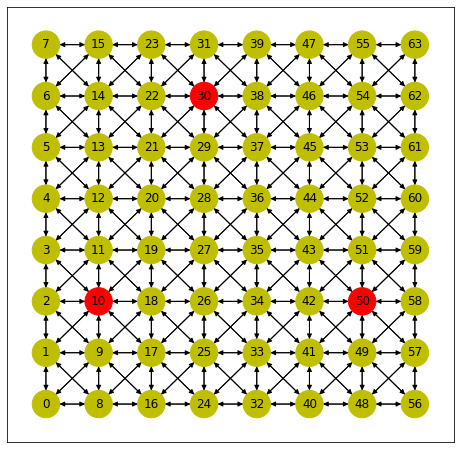

In [ ]:
graph = pyg.utils.to_networkx(data)
pos = {}
for idx in range(64):
    x,y = to_coord(idx)
    pos[idx] = np.array([x,y])

fig, ax = plt.subplots(figsize=(8, 8))
color = ['y' for i in range(64)]
for coin in COINS:
    color[coin] = 'r'
nx.drawing.nx_pylab.draw_networkx(graph, node_color=color, pos=pos, node_size=750, ax=ax)

In [ ]:
def plot_policy(policy):
    u = [[0.75 for i in range(8)] for j in range(8)]
    v = [[0.75 for i in range(8)] for j in range(8)]
    for state in range(64):
        x,y = to_coord(state)
        action = np.argmax(policy[state])
        if action==0:
            u[y][x] = 0
            v[y][x] = 0.75
        elif action==1:
            u[y][x] = 0.75
            v[y][x] = 0.75
        elif action==2:
            u[y][x] = 0.75
            v[y][x] = 0
        elif action==3:
            u[y][x] = 0.75
            v[y][x] = -0.75
        elif action==4:
            u[y][x] = 0
            v[y][x] = -0.75
        elif action==5:
            u[y][x] = -0.75
            v[y][x] = -0.75
        elif action==6:
            u[y][x] = -0.75
            v[y][x] = 0
        else:
            u[y][x] = -0.75
            v[y][x] = 0.75

    graph = pyg.utils.to_networkx(data)
    pos = {}
    for idx in range(64):
        x,y = to_coord(idx)
        pos[idx] = np.array([x,y])

    fig, ax = plt.subplots(figsize=(8, 8))
    color = ['y' for i in range(64)]
    for coin in COINS:
        color[coin] = 'r'
    nx.drawing.nx_pylab.draw_networkx(graph, node_color=color, pos=pos, node_size=750, ax=ax, edgelist=[])
    
    X = np.arange(0,8,1)
    Y = np.arange(0,8,1)

    ax.quiver(X, Y, u, v, scale_units='xy', scale=1)
    
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect('equal')
    plt.grid()
    plt.show()

## 3. Define random walker and Initialize policy

In [ ]:
POLICY = {}
for i in range(8):
    for j in range(8):
        u = to_node_idx(i,j)
        POLICY[u] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        if j<7: # up
            POLICY[u][0] = 1.0
        if j<7 and i<7: # up-right
            POLICY[u][1] = 1.0
        if i<7: # right
            POLICY[u][2] = 1.0
        if i<7 and j>0: # down-right
            POLICY[u][3] = 1.0
        if j>0: # down
            POLICY[u][4] = 1.0
        if j>0 and i>0: # down-left
            POLICY[u][5] = 1.0
        if i>0: # left
            POLICY[u][6] = 1.0
        if j<7 and i>0: # up-left
            POLICY[u][7] = 1.0
        POLICY[u] /= sum(POLICY[u])

Q = {}
for i in range(8):
    for j in range(8):
        u = to_node_idx(i,j)
        Q[u] = {}
        if j<7: # up
            Q[u][0] = torch.rand(1)
        if j<7 and i<7: # up-right
            Q[u][1] = torch.rand(1)
        if i<7: # right
            Q[u][2] = torch.rand(1)
        if i<7 and j>0: # down-right
            Q[u][3] = torch.rand(1)
        if j>0: # down
            Q[u][4] = torch.rand(1)
        if j>0 and i>0: # down-left
            Q[u][5] = torch.rand(1)
        if i>0: # left
            Q[u][6] = torch.rand(1)
        if j<7 and i>0: # up-left
            Q[u][7] = torch.rand(1)

RET = {}
for i in range(8):
    for j in range(8):
        u = to_node_idx(i,j)
        RET[u] = [[], [], [], [], [], [], [], []]

In [ ]:
def sample_episode(walk_len, start_node=None):
    if start_node==None:
        start_node = np.random.randint(0,NUM_NODES)
    states = []
    actions = []
    rewards = []
    curr_state = start_node
    while len(states) < walk_len:
        states.append(curr_state)
        if curr_state in COINS:
            rewards.append(1.0)
        else:
            rewards.append(0.0)
        actions.append(np.random.choice(a=[0,1,2,3,4,5,6,7], size=None, replace=True, p=POLICY[curr_state]))
        if actions[-1]==0:      # up
            curr_state = to_node_idx(to_coord(curr_state)[0], to_coord(curr_state)[1]+1)
        elif actions[-1]==1:      # up-right
            curr_state = to_node_idx(to_coord(curr_state)[0]+1, to_coord(curr_state)[1]+1)
        elif actions[-1]==2:    # right
            curr_state = to_node_idx(to_coord(curr_state)[0]+1, to_coord(curr_state)[1])
        elif actions[-1]==3:      # down-right
            curr_state = to_node_idx(to_coord(curr_state)[0]+1, to_coord(curr_state)[1]-1)
        elif actions[-1]==4:    # down
            curr_state = to_node_idx(to_coord(curr_state)[0], to_coord(curr_state)[1]-1)
        elif actions[-1]==5:      # down-left
            curr_state = to_node_idx(to_coord(curr_state)[0]-1, to_coord(curr_state)[1]-1)
        elif actions[-1]==6:    # left
            curr_state = to_node_idx(to_coord(curr_state)[0]-1, to_coord(curr_state)[1])
        else:      # up-left
            curr_state = to_node_idx(to_coord(curr_state)[0]-1, to_coord(curr_state)[1]+1)
    return states, actions, rewards

## Build models

In [ ]:
# Set Hyperparameters
EMBED_DIM = 512
EPS = 1e-15
INIT_LR1 = 0.1

WALK_LEN = 128
INIT_LR2 = 1e-3

In [ ]:
class Node2Vec(torch.nn.Module):
    def __init__(self, embedding_dim=EMBED_DIM, num_nodes=NUM_NODES, sparse=False):
        super(Node2Vec, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = torch.nn.Embedding(num_nodes, embedding_dim, sparse=sparse)
        self.reset_parameters()


    def reset_parameters(self):
        self.embedding.reset_parameters()


    def forward(self, batch=None):
        emb = self.embedding.weight
        return emb if batch is None else emb[batch]


    def loss(self, pos_rw, neg_rw):
        start, rest = pos_rw[:, 0], pos_rw[:, 1:].contiguous()
        h_start = self.embedding(start).view(pos_rw.size(0), 1, self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(pos_rw.size(0), -1, self.embedding_dim)
        out = (h_start * h_rest).sum(dim=-1).view(-1)
        pos_loss = -torch.log(torch.sigmoid(out) + EPS).mean()

        start, rest = neg_rw[:, 0], neg_rw[:, 1:].contiguous()
        h_start = self.embedding(start).view(neg_rw.size(0), 1, self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(neg_rw.size(0), -1, self.embedding_dim)

        out = (h_start * h_rest).sum(dim=-1).view(-1)
        neg_loss = -torch.log(1 - torch.sigmoid(out) + EPS).mean()
        return pos_loss + neg_loss

model1 = Node2Vec().to(DEVICE)
optimizer1 = torch.optim.Adam(model1.parameters(), INIT_LR1)
platLR1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='min', factor=0.5, patience=1, threshold=0.0001, 
                                                    threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-10, verbose=False)

In [ ]:
def get_contexts(walks, size):
    batch = torch.tensor([], dtype=torch.int, requires_grad=False).to(DEVICE)
    for sequence in walks:
        for i in range(0,len(sequence)-size):
            batch = torch.cat((batch, sequence[i:i+size].reshape(1,size)), axis=0)
    return batch

In [ ]:
class InferNet(torch.nn.Module):
    def __init__ (self, input_len=EMBED_DIM):
        super(InferNet, self).__init__()
        self.input_size = input_len
        self.lin1 = torch.nn.Linear(self.input_size,512)
        self.lin4 = torch.nn.Linear(512,1)

    def forward(self, X):
        X = torch.tanh(self.lin1(X))
        X = self.lin4(X)
        return X

model2 = InferNet().to(DEVICE)
optimizer2 = torch.optim.Adam(model2.parameters(), INIT_LR2)
platLR2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', factor=0.5, patience=1, threshold=0.0001, 
                                                    threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-10, verbose=False)

In [ ]:
mse = torch.nn.MSELoss(reduction='sum')
def getLoss2(imm_rewards, rewards):
    main_loss = mse(torch.sum(imm_rewards), torch.sum(rewards)) / WALK_LEN
    return main_loss

In [ ]:
def printRewards(rewards):
    matrix = np.array([[float(rewards[to_node_idx(i,j)][0]) for i in range(8)] for j in range(8)])
    cm = sns.light_palette("blue", as_cmap=True)
    x=pd.DataFrame(matrix).iloc[::-1]
    x=x.style.background_gradient(cmap=cm, axis=None)
    display(x)

## Train models

In [ ]:
NUM_ITER = 50
CONT_SIZE = 3
NUM_NEG = 1
losses1 = []
losses2 = []
# GAMMA = 0.5

model2.eval()
all_states = model1.forward(torch.tensor([i for i in range(NUM_NODES)])).reshape(NUM_NODES,EMBED_DIM)
imm_rewards = model2.forward(all_states).reshape(NUM_NODES,1)
printRewards(imm_rewards)

for iter in range(1,NUM_ITER+1):
    states, actions, rewards = [], [], []
    for start in range(NUM_NODES):
        s, a, r = sample_episode(WALK_LEN, start)
        states.append(s)
        actions.append(a)
        rewards.append(r)
    neg_samples = torch.randint(low=0, high=NUM_NODES, size=(NUM_NODES,(WALK_LEN*NUM_NEG)-1))
    neg_samples = neg_samples.reshape(NUM_NODES, (WALK_LEN*NUM_NEG)-1)

    states = torch.tensor(states).to(DEVICE)
    actions = torch.tensor(actions).to(DEVICE)
    rewards = torch.tensor(rewards).to(DEVICE)
    neg_samples = torch.cat((states[:,0].reshape(NUM_NODES,1), neg_samples.to(DEVICE)), axis=1)

    model1.train()
    optimizer1.zero_grad()
    pos = get_contexts(states, CONT_SIZE)
    neg = get_contexts(neg_samples, CONT_SIZE)
    loss1 = model1.loss(pos.to(DEVICE), neg.to(DEVICE))
    loss1.backward()
    optimizer1.step()
    loss1 = float(loss1)
    platLR1.step(loss1)
    
    model2.train()
    loss2 = 0.0
    for i in range(NUM_NODES):
        optimizer2.zero_grad()
        ep_states = model1.forward(states[i,:].reshape(WALK_LEN)).reshape(WALK_LEN,EMBED_DIM)
        imm_rewards = model2.forward(ep_states).reshape(WALK_LEN,1)
        L = getLoss2(imm_rewards, rewards[i].reshape(WALK_LEN,1))
        L.backward()
        optimizer2.step()
        loss2 += float(L)
    loss2 /= float(NUM_NODES)
    platLR2.step(loss2)

    # if len(losses1)>0:
    #     loss1 = (GAMMA*loss1) + ((1-GAMMA)*losses1[-1])
    # if len(losses2)>0:
    #     loss2 = (GAMMA*loss2) + ((1-GAMMA)*losses2[-1])

    print("iter : "+str(iter)+" |  loss1 : "+str(np.around(loss1,6))+" |  loss2 : "+str(np.around(loss2,6)))
    losses1.append(loss1)
    losses2.append(loss2)

    if iter in [10, 25, 50]:
        model2.eval()
        all_states = model1.forward(torch.tensor([i for i in range(NUM_NODES)])).reshape(NUM_NODES,EMBED_DIM)
        imm_rewards = model2.forward(all_states).reshape(NUM_NODES,1)
        printRewards(imm_rewards)

,0,1,2,3,4,5,6,7
7,0.476522,-0.047226,-0.078334,-0.113890,-0.112307,-0.077897,-0.056860,-0.193182
6,-0.217227,0.449050,-0.253179,0.222002,-0.027036,0.246256,-0.162212,-0.286815
5,0.506386,0.082366,0.306199,-0.037394,-0.165799,0.143218,0.138173,-0.189759
4,-0.488101,0.006839,0.022729,0.290967,-0.300160,-0.069967,-0.169547,-0.211054
3,0.007664,-0.277316,0.244599,0.205027,0.196127,0.139028,0.417372,0.360891
2,-0.194938,0.070811,-0.375516,-0.089531,-0.094787,0.238499,-0.115760,-0.220435
1,0.131425,0.726761,0.018675,-0.322981,0.216040,0.199119,0.626912,-0.070740
0,0.025977,0.212268,0.275828,-0.270882,-0.411361,0.278527,-0.187398,0.193604


iter : 1 |  loss1 : 18.854073 |  loss2 : 13.311949
iter : 2 |  loss1 : 13.683125 |  loss2 : 0.938823
iter : 3 |  loss1 : 12.18894 |  loss2 : 0.300061
iter : 4 |  loss1 : 11.846163 |  loss2 : 0.108441
iter : 5 |  loss1 : 11.615489 |  loss2 : 0.062022
iter : 6 |  loss1 : 11.182859 |  loss2 : 0.030044
iter : 7 |  loss1 : 10.946642 |  loss2 : 0.050167
iter : 8 |  loss1 : 10.730477 |  loss2 : 0.01184
iter : 9 |  loss1 : 10.536671 |  loss2 : 0.05752
iter : 10 |  loss1 : 10.206418 |  loss2 : 0.120273


,0,1,2,3,4,5,6,7
7,0.152879,0.028635,-0.015343,0.059580,0.236482,0.022972,-0.149565,-0.101139
6,-0.098665,0.055937,-0.197836,0.711500,0.185879,0.017316,0.017447,-0.214684
5,0.238035,0.149485,-0.029720,0.042362,0.170940,0.227016,-0.125368,-0.154098
4,-0.151408,-0.095573,-0.272390,0.005452,-0.031569,0.212119,0.147939,-0.029013
3,0.160376,0.297949,-0.099921,0.004908,0.012848,-0.089612,0.169635,0.307138
2,-0.198865,0.712970,0.084124,0.362677,-0.045279,-0.231547,0.721481,0.178396
1,-0.248447,0.068011,0.131554,0.074625,0.009069,-0.070080,0.126494,0.030849
0,0.029100,-0.139290,0.331818,-0.089634,0.012411,-0.262707,-0.246808,-0.178708


iter : 11 |  loss1 : 10.105071 |  loss2 : 0.044958
iter : 12 |  loss1 : 9.960142 |  loss2 : 0.032002
iter : 13 |  loss1 : 10.023799 |  loss2 : 0.017139
iter : 14 |  loss1 : 10.015869 |  loss2 : 0.011487
iter : 15 |  loss1 : 9.71533 |  loss2 : 0.007203
iter : 16 |  loss1 : 9.581655 |  loss2 : 0.006629
iter : 17 |  loss1 : 9.396087 |  loss2 : 0.005669
iter : 18 |  loss1 : 9.42003 |  loss2 : 0.006346
iter : 19 |  loss1 : 9.275849 |  loss2 : 0.007067
iter : 20 |  loss1 : 9.214088 |  loss2 : 0.003956
iter : 21 |  loss1 : 9.250169 |  loss2 : 0.004733
iter : 22 |  loss1 : 9.273163 |  loss2 : 0.002434
iter : 23 |  loss1 : 9.130705 |  loss2 : 0.002797
iter : 24 |  loss1 : 9.053638 |  loss2 : 0.003402
iter : 25 |  loss1 : 9.410683 |  loss2 : 0.003558


,0,1,2,3,4,5,6,7
7,0.006660,0.055155,0.107952,0.032708,0.102582,-0.022159,-0.004593,0.012318
6,-0.088495,0.003163,-0.048281,0.827204,0.082246,-0.107332,0.080060,-0.034247
5,-0.014400,0.071360,0.047091,0.023442,0.064349,-0.036762,0.021240,-0.038982
4,-0.149300,0.002164,-0.022003,-0.030737,-0.018045,0.027630,-0.081213,-0.043553
3,0.113042,0.076938,0.027357,-0.042276,-0.019397,0.041617,0.082175,0.053965
2,-0.023645,0.842687,0.012717,0.029971,0.023449,-0.032466,0.862565,0.008531
1,0.016206,0.067369,0.045502,-0.063693,0.016503,0.085267,0.065071,0.063402
0,-0.010622,-0.079849,0.102549,-0.053289,0.044731,-0.078689,-0.031835,-0.069173


iter : 26 |  loss1 : 8.82815 |  loss2 : 0.002253
iter : 27 |  loss1 : 9.114285 |  loss2 : 0.003009
iter : 28 |  loss1 : 9.124572 |  loss2 : 0.002721
iter : 29 |  loss1 : 9.214433 |  loss2 : 0.002957
iter : 30 |  loss1 : 8.875691 |  loss2 : 0.002627
iter : 31 |  loss1 : 8.90794 |  loss2 : 0.001684
iter : 32 |  loss1 : 8.877952 |  loss2 : 0.002145
iter : 33 |  loss1 : 9.084883 |  loss2 : 0.001816
iter : 34 |  loss1 : 8.842264 |  loss2 : 0.003046
iter : 35 |  loss1 : 8.85383 |  loss2 : 0.0022
iter : 36 |  loss1 : 8.732239 |  loss2 : 0.001681
iter : 37 |  loss1 : 8.685324 |  loss2 : 0.002293
iter : 38 |  loss1 : 8.829358 |  loss2 : 0.002304
iter : 39 |  loss1 : 8.813309 |  loss2 : 0.002178
iter : 40 |  loss1 : 8.839278 |  loss2 : 0.002521
iter : 41 |  loss1 : 8.984371 |  loss2 : 0.001756
iter : 42 |  loss1 : 8.931166 |  loss2 : 0.00218
iter : 43 |  loss1 : 8.774843 |  loss2 : 0.002287
iter : 44 |  loss1 : 8.914617 |  loss2 : 0.001477
iter : 45 |  loss1 : 8.895617 |  loss2 : 0.001493
iter :

,0,1,2,3,4,5,6,7
7,-0.003426,0.037842,0.093030,0.024819,0.101947,-0.020161,-0.002553,0.004272
6,-0.085772,-0.004128,-0.050178,0.835663,0.070919,-0.100992,0.077358,-0.029246
5,-0.008172,0.075791,0.047265,0.018348,0.054789,-0.029594,0.039064,-0.027306
4,-0.131558,0.004384,-0.022189,-0.032692,-0.010930,0.029209,-0.065601,-0.030819
3,0.115530,0.068269,0.028760,-0.035304,-0.022153,0.033556,0.069574,0.052204
2,-0.016105,0.858829,0.012662,0.024987,0.012918,-0.036983,0.869071,-0.010813
1,0.022587,0.049758,0.037231,-0.063799,0.016747,0.077065,0.059448,0.059577
0,-0.026140,-0.092128,0.089829,-0.050354,0.047463,-0.069771,-0.026747,-0.064133


In [ ]:
printRewards(rewards[:,0].reshape(NUM_NODES,1))

,0,1,2,3,4,5,6,7
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


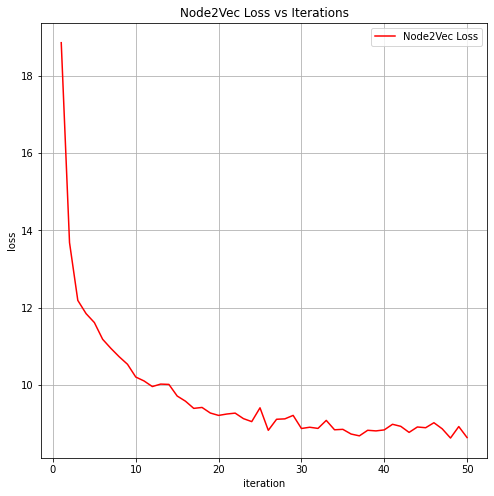

In [ ]:
x = [i for i in range(1,NUM_ITER+1)]
plt.figure(figsize=(8,8))
plt.plot(x, losses1, 'r', label='Node2Vec Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.title("Node2Vec Loss vs Iterations")
fig.savefig('Node2VecLoss_iter.png')

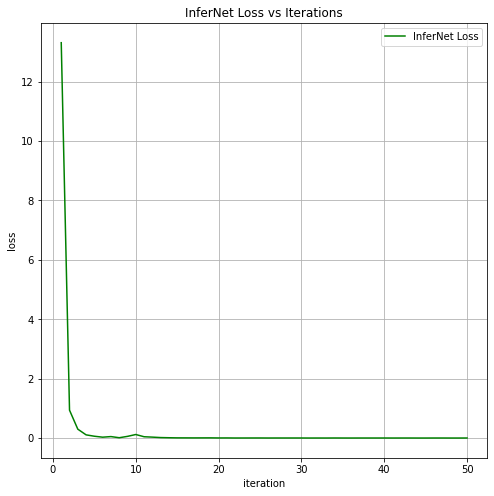

In [ ]:
x = [i for i in range(1,NUM_ITER+1)]
plt.figure(figsize=(8,8))
plt.plot(x, list(losses2), 'g', label='InferNet Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.title("InferNet Loss vs Iterations")
fig.savefig('InferNetLoss_iter.png')

## Improve policy

In [ ]:
def improvePolicy(policy, Q, state, eps=0.1):
    q = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    for a in [0, 1, 2, 3, 4, 5, 6, 7]:
        if a in Q[state].keys():
            q[a] = Q[state][a]

    policy[state] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    idx = 0
    _, indices = torch.sort(q, descending=True)
    policy[state][indices[idx]] = (1.0-eps)
    # if indices[0]==7:
        # print("state =", state)
        # print("policy =", policy[state])
    while ((state+1)%8 == 0 and indices[idx]==0) or (((state+1)%8 == 0 or (state>=56 and state<=63)) and indices[idx]==1) or (state>=56 and state<=63 and indices[idx]==2) or (((state>=56 and state<=63) or state%8 == 0) and indices[idx]==3) or (state%8 == 0 and indices[idx]==4) or ((state%8 == 0 or (state>=0 and state<=7)) and indices[idx]==5) or (state>=0 and state<=7 and indices[idx]==6) or (((state+1)%8 == 0 or (state>=0 and state<=7)) and indices[idx]==7):
        policy[state][indices[idx]] = 0.0
        idx += 1
        policy[state][indices[idx]] = (1.0-eps)

    num_actions = 8.0
    if (state+1)%8 == 0:
        num_actions -= 1.0
    if (state+1)%8 == 0 or (state>=56 and state<=63):
        num_actions -= 1.0
    if state>=56 and state<=63:
        num_actions -= 1.0
    if (state>=56 and state<=63) or state%8 == 0:
        num_actions -= 1.0
    if state%8 == 0:
        num_actions -= 1.0
    if state%8 == 0 or (state>=0 and state<=7):
        num_actions -= 1.0
    if state>=0 and state<=7:
        num_actions -= 1.0
    if (state+1)%8 == 0 or (state>=0 and state<=7):
        num_actions -= 1.0

    if not ((state+1)%8 == 0):
        policy[state][0] += (eps/num_actions)
    if not ((state+1)%8 == 0 or (state>=56 and state<=63)):
        policy[state][1] += (eps/num_actions)
    if not (state>=56 and state<=63):
        policy[state][2] += (eps/num_actions)
    if not ((state>=56 and state<=63) or state%8 == 0):
        policy[state][3] += (eps/num_actions)
    if state%8 != 0:
        policy[state][4] += (eps/num_actions)
    if not (state%8 == 0 or (state>=0 and state<=7)):
        policy[state][5] += (eps/num_actions)
    if not (state>=0 and state<=7):
        policy[state][6] += (eps/num_actions)
    if not ((state+1)%8 == 0 or (state>=0 and state<=7)):
        policy[state][7] += (eps/num_actions)    
    return policy

In [ ]:
def walk_freq():
    freq = {}
    for i in range(1000):
        for start in range(NUM_NODES):
            states, a, r = sample_episode(8, start)
            for s in states:
                if s not in freq.keys():
                    freq[s] = 0
                freq[s] += 1
    matrix = np.array([[int(freq[to_node_idx(i,j)]) for i in range(8)] for j in range(8)])
    cm = sns.light_palette("green", as_cmap=True)
    x=pd.DataFrame(matrix).iloc[::-1]
    x=x.style.background_gradient(cmap=cm, axis=None)
    display(x)

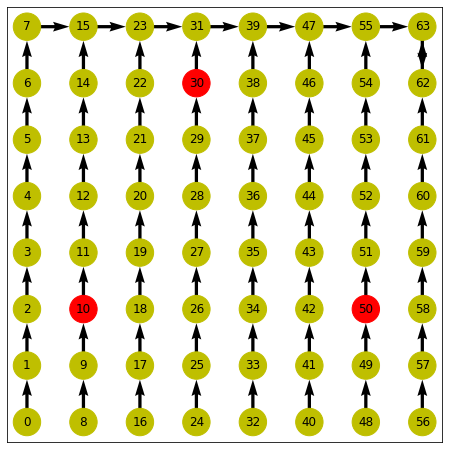

In [ ]:
plot_policy(POLICY)

In [ ]:
model1.eval()
model2.eval()
all_states = model1.forward(torch.tensor([i for i in range(NUM_NODES)])).reshape(NUM_NODES,EMBED_DIM)
imm_rewards = model2.forward(all_states).reshape(NUM_NODES,1)

In [ ]:
cum_reward = []
epsilon = 0.98
model2.eval()
NUM_ITER = 300
WALK_LEN = 5
walk_freq()

for iter in range(1,NUM_ITER+1):
    states, actions, rewards = [], [], []
    for start in range(NUM_NODES):
        s, a, r = sample_episode(WALK_LEN, start)
        states.append(s)
        actions.append(a)
        rewards.append(r)
    
    for i in range(NUM_NODES):
        G = 0.0
        for j in reversed(range(WALK_LEN-1)):
            G += float(imm_rewards[states[i][j+1]])
            s = states[i][j]
            a = actions[i][j]
            vis_prev = False
            for k in range(j):
                if states[i][k]==s and actions[i][k]==a:
                    vis_prev = True
                    break
            if vis_prev:
                continue
            
            RET[s][a].append(G)
            Q[s][a] = np.mean(RET[s][a])
            POLICY = improvePolicy(POLICY, Q, s, epsilon)

    epsilon *= 0.98
    rewards = torch.tensor(rewards).to(DEVICE)
    
    cm = float(torch.sum(rewards))/float(NUM_NODES)
    # if len(cum_reward)>0:
        # cm = (GAMMA*cm) + ((1-GAMMA)*cum_reward[-1])
    cum_reward.append(cm)

    print("iter : "+str(iter)+" |  cum_reward : "+str(cum_reward[-1]))
    if iter in [5, 10, 20, 30, 50, 75, 150, 300]:
        walk_freq()

,0,1,2,3,4,5,6,7
7,4415,6926,6688,6549,6401,6392,6791,4530
6,6846,10284,9668,9459,9404,9643,10062,6822
5,6586,9626,9235,8995,8994,9022,9501,6532
4,6294,9238,8706,8629,8797,9029,9413,6382
3,6409,9061,8788,8525,8709,8870,9465,6294
2,6654,9628,9100,8882,8969,9181,9571,6651
1,7068,10317,9632,9447,9431,9623,10122,6951
0,4640,7036,6509,6393,6452,6471,6798,4494


iter : 1 |  cum_reward : 0.265625
iter : 2 |  cum_reward : 0.21875
iter : 3 |  cum_reward : 0.328125
iter : 4 |  cum_reward : 0.3125
iter : 5 |  cum_reward : 0.40625


,0,1,2,3,4,5,6,7
7,4025,6638,7761,6948,8254,6203,6104,4073
6,5858,9222,9189,14796,9923,8927,10694,6776
5,5463,8555,9122,9170,8941,8565,9148,5695
4,5647,8477,8209,7858,7530,7655,8099,5583
3,6484,9810,11474,8517,7499,8803,8807,6475
2,6313,13738,9727,8854,8215,9642,15195,6590
1,6387,9645,8613,8676,9592,11512,9853,8401
0,4032,5898,6067,5544,5720,6036,6568,4205


iter : 6 |  cum_reward : 0.359375
iter : 7 |  cum_reward : 0.359375
iter : 8 |  cum_reward : 0.46875
iter : 9 |  cum_reward : 0.546875
iter : 10 |  cum_reward : 0.453125


,0,1,2,3,4,5,6,7
7,3412,6930,8892,7442,10877,5882,5705,5405
6,4898,7826,10322,20791,10263,8141,10951,5555
5,4380,7213,7752,10078,9135,7203,7029,4828
4,4643,6998,6811,6693,6900,8420,7568,5212
3,6895,8459,10441,6420,7883,9654,13395,7266
2,9355,19340,7950,6806,7200,11300,21140,6925
1,6518,9638,8987,7544,7946,12076,9251,6929
0,3528,5238,5631,4797,4969,5226,5534,3604


iter : 11 |  cum_reward : 0.515625
iter : 12 |  cum_reward : 0.59375
iter : 13 |  cum_reward : 0.78125
iter : 14 |  cum_reward : 0.6875
iter : 15 |  cum_reward : 0.75
iter : 16 |  cum_reward : 0.703125
iter : 17 |  cum_reward : 0.59375
iter : 18 |  cum_reward : 0.625
iter : 19 |  cum_reward : 0.71875
iter : 20 |  cum_reward : 0.625


,0,1,2,3,4,5,6,7
7,2653,5245,7628,7444,16919,5267,4481,2565
6,3543,7745,9839,31671,10370,7024,7753,3773
5,3318,5252,10861,10375,8632,5470,7639,3890
4,3830,5513,5257,5254,5387,8331,6903,6067
3,8936,8199,7575,4442,5001,11344,18828,8304
2,14867,29743,8197,4580,5046,8177,31014,6823
1,8301,10889,8999,4691,4986,13008,7890,6470
0,3333,4629,3809,3265,3586,3922,4394,2853


iter : 21 |  cum_reward : 0.796875
iter : 22 |  cum_reward : 0.984375
iter : 23 |  cum_reward : 0.78125
iter : 24 |  cum_reward : 0.890625
iter : 25 |  cum_reward : 0.796875
iter : 26 |  cum_reward : 0.859375
iter : 27 |  cum_reward : 0.953125
iter : 28 |  cum_reward : 0.984375
iter : 29 |  cum_reward : 1.0
iter : 30 |  cum_reward : 0.890625


,0,1,2,3,4,5,6,7
7,2238,5567,7887,7656,24985,9028,4129,2104
6,2903,5570,8927,42662,12745,6577,5304,2598
5,2399,3846,9859,10043,8005,4179,3779,2624
4,3008,4342,4015,4056,4169,6452,5550,5171
3,9117,7559,6602,3311,3724,12292,24495,8168
2,20214,37254,7238,3494,3900,7176,38881,6379
1,6559,11617,8317,3540,3544,9447,7655,6041
0,2701,3573,3096,2540,2510,2852,3402,2425


iter : 31 |  cum_reward : 1.015625
iter : 32 |  cum_reward : 0.921875
iter : 33 |  cum_reward : 1.15625
iter : 34 |  cum_reward : 1.125
iter : 35 |  cum_reward : 1.015625
iter : 36 |  cum_reward : 0.90625
iter : 37 |  cum_reward : 0.984375
iter : 38 |  cum_reward : 1.234375
iter : 39 |  cum_reward : 1.140625
iter : 40 |  cum_reward : 1.125
iter : 41 |  cum_reward : 1.125
iter : 42 |  cum_reward : 1.109375
iter : 43 |  cum_reward : 1.28125
iter : 44 |  cum_reward : 1.40625
iter : 45 |  cum_reward : 1.25
iter : 46 |  cum_reward : 1.234375
iter : 47 |  cum_reward : 1.1875
iter : 48 |  cum_reward : 1.265625
iter : 49 |  cum_reward : 1.1875
iter : 50 |  cum_reward : 1.3125


,0,1,2,3,4,5,6,7
7,1574,4379,6868,6557,37491,8613,2308,1500
6,1825,2887,6524,56349,12106,5321,4663,1812
5,1766,2481,8180,6563,8476,2798,2502,1894
4,3264,3883,3473,3725,2771,5140,4022,4246
3,7850,5710,30936,3146,2481,11725,32610,7479
2,4124,45802,7201,3300,2670,5668,50901,5298
1,3785,8017,6478,2284,2359,9685,6015,5069
0,1722,2215,1930,1728,1831,2032,2291,1697


iter : 51 |  cum_reward : 1.40625
iter : 52 |  cum_reward : 1.34375
iter : 53 |  cum_reward : 1.5
iter : 54 |  cum_reward : 1.296875
iter : 55 |  cum_reward : 1.34375
iter : 56 |  cum_reward : 1.421875
iter : 57 |  cum_reward : 1.296875
iter : 58 |  cum_reward : 1.453125
iter : 59 |  cum_reward : 1.390625
iter : 60 |  cum_reward : 1.484375
iter : 61 |  cum_reward : 1.5
iter : 62 |  cum_reward : 1.390625
iter : 63 |  cum_reward : 1.546875
iter : 64 |  cum_reward : 1.421875
iter : 65 |  cum_reward : 1.46875
iter : 66 |  cum_reward : 1.578125
iter : 67 |  cum_reward : 1.515625
iter : 68 |  cum_reward : 1.515625
iter : 69 |  cum_reward : 1.46875
iter : 70 |  cum_reward : 1.375
iter : 71 |  cum_reward : 1.375
iter : 72 |  cum_reward : 1.5625
iter : 73 |  cum_reward : 1.59375
iter : 74 |  cum_reward : 1.421875
iter : 75 |  cum_reward : 1.46875


,0,1,2,3,4,5,6,7
7,1260,3623,5845,4939,49237,7592,1678,1241
6,1416,1959,4664,66404,10836,3837,3858,1394
5,1290,1706,6423,4775,6500,1903,1677,1441
4,2518,2706,2551,2589,1888,3924,2911,3489
3,6549,3953,40611,2455,1726,9888,43139,6264
2,2921,53536,5531,2436,1814,4046,59675,3952
1,2727,6502,5125,1615,1653,7822,4400,3858
0,1373,1561,1517,1375,1412,1511,1612,1367


iter : 76 |  cum_reward : 1.625
iter : 77 |  cum_reward : 1.59375
iter : 78 |  cum_reward : 1.609375
iter : 79 |  cum_reward : 1.484375
iter : 80 |  cum_reward : 1.4375
iter : 81 |  cum_reward : 1.5
iter : 82 |  cum_reward : 1.640625
iter : 83 |  cum_reward : 1.625
iter : 84 |  cum_reward : 1.625
iter : 85 |  cum_reward : 1.6875
iter : 86 |  cum_reward : 1.578125
iter : 87 |  cum_reward : 1.546875
iter : 88 |  cum_reward : 1.578125
iter : 89 |  cum_reward : 1.609375
iter : 90 |  cum_reward : 1.671875
iter : 91 |  cum_reward : 1.65625
iter : 92 |  cum_reward : 1.65625
iter : 93 |  cum_reward : 1.609375
iter : 94 |  cum_reward : 1.71875
iter : 95 |  cum_reward : 1.65625
iter : 96 |  cum_reward : 1.578125
iter : 97 |  cum_reward : 1.609375
iter : 98 |  cum_reward : 1.703125
iter : 99 |  cum_reward : 1.609375
iter : 100 |  cum_reward : 1.625
iter : 101 |  cum_reward : 1.65625
iter : 102 |  cum_reward : 1.5625
iter : 103 |  cum_reward : 1.734375
iter : 104 |  cum_reward : 1.765625
iter : 10

,0,1,2,3,4,5,6,7
7,1047,3101,4426,1987,64679,5613,1109,1028
6,1060,1150,2545,76648,7200,1728,3118,1053
5,1049,1097,3819,2536,3797,1139,1098,1075
4,2091,1397,1341,1352,1098,2472,1395,2341
3,4691,1693,54496,1331,1089,6301,58344,3895
2,1386,63166,2915,1339,1114,1761,69591,1727
1,1395,4466,3502,1082,1094,5572,2501,2425
0,1051,1084,1058,1056,1071,1069,1091,1055


iter : 151 |  cum_reward : 1.8125
iter : 152 |  cum_reward : 1.78125
iter : 153 |  cum_reward : 1.84375
iter : 154 |  cum_reward : 1.796875
iter : 155 |  cum_reward : 1.828125
iter : 156 |  cum_reward : 1.859375
iter : 157 |  cum_reward : 1.84375
iter : 158 |  cum_reward : 1.8125
iter : 159 |  cum_reward : 1.8125
iter : 160 |  cum_reward : 1.84375
iter : 161 |  cum_reward : 1.875
iter : 162 |  cum_reward : 1.828125
iter : 163 |  cum_reward : 1.84375
iter : 164 |  cum_reward : 1.828125
iter : 165 |  cum_reward : 1.84375
iter : 166 |  cum_reward : 1.859375
iter : 167 |  cum_reward : 1.859375
iter : 168 |  cum_reward : 1.859375
iter : 169 |  cum_reward : 1.859375
iter : 170 |  cum_reward : 1.875
iter : 171 |  cum_reward : 1.875
iter : 172 |  cum_reward : 1.875
iter : 173 |  cum_reward : 1.890625
iter : 174 |  cum_reward : 1.890625
iter : 175 |  cum_reward : 1.859375
iter : 176 |  cum_reward : 1.90625
iter : 177 |  cum_reward : 1.875
iter : 178 |  cum_reward : 1.859375
iter : 179 |  cum_re

,0,1,2,3,4,5,6,7
7,1002,3004,4015,1066,68802,5031,1005,1002
6,1005,1005,2029,78923,6079,1034,3001,1001
5,1004,1004,3035,2042,3045,1005,1004,1003
4,2004,1015,1017,1027,1008,2025,1018,2020
3,4032,1038,58747,1016,1003,5054,62767,3041
2,1024,65838,2047,1012,1006,1044,71868,1025
1,1021,4024,3015,1004,1003,5034,2020,2013
0,1000,1008,1003,1000,1005,1002,1004,1002


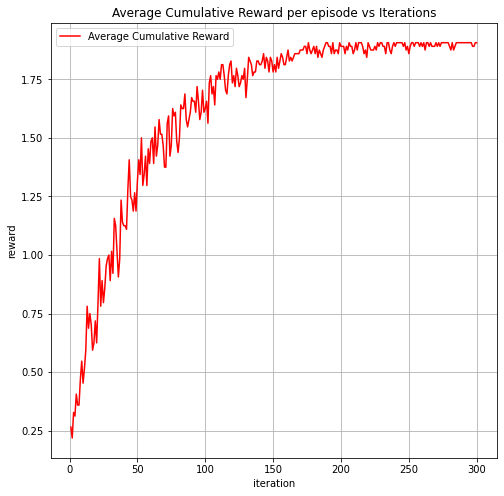

In [ ]:
x = [i for i in range(1,len(cum_reward)+1)]
plt.figure(figsize=(8,8))
plt.plot(x, cum_reward, 'r', label='Average Cumulative Reward')
plt.xlabel('iteration')
plt.ylabel('reward')
plt.grid()
plt.legend()
plt.title("Average Cumulative Reward per episode vs Iterations")
fig.savefig('CumReward_iter.png')

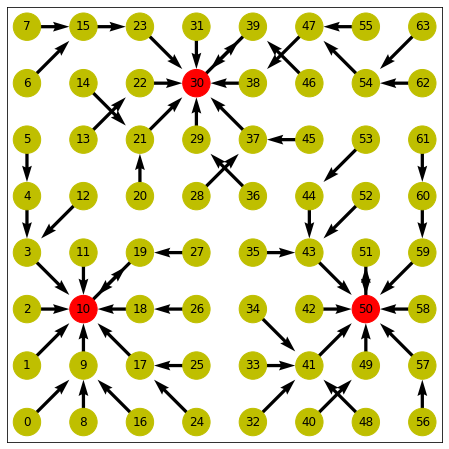

In [ ]:
plot_policy(POLICY)